# Master File

# Tools & Libraries

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [2]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import boxplot_histogram

In [3]:
from pa_lib.data import desc_col

# Load Dataset (Data Preparation)

In [4]:
from vkprog_data_prep import bd_train_scoring


In [5]:
%%time
# Wall time: 38.5 s

(training_all, scoring_all, feature_colnames_bd, feature_colnames_dates,feature_colnames_branchen) = bd_train_scoring(
    day=7,
    month=10,
    year_score=2019,
    year_train=2018,
    year_span=4,
    scale_features=True)

2019-10-10 17:28:30 [INFO] Started loading binary file
2019-10-10 17:28:30 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
2019-10-10 17:28:30 [INFO] Finished loading binary file in 0.18s (0.92s CPU)
2019-10-10 17:28:31 [INFO] Period: KW_2
2019-10-10 17:28:31 [INFO] Calculate Reservation...
2019-10-10 17:28:32 [INFO] Calculate Aushang...
2019-10-10 17:28:32 [INFO] Merge Results...
2019-10-10 17:28:32 [INFO] aggregate_bookings: Done.
2019-10-10 17:28:32 [INFO] current_yyyykw: 201941
2019-10-10 17:28:32 [INFO] training_yyyykw:201841
2019-10-10 17:28:32 [INFO] Computing: Pivot Table
2019-10-10 17:28:33 [INFO] Running: booking_yearly_totals(YYYYKW, year_span) 
2019-10-10 17:28:33 [INFO] Computing: Yearly total sums
2019-10-10 17:28:33 [INFO] Merging: Left-Join to Container dataframe
2019-10-10 17:28:33 [INFO] Merging: Left-Join to Container dataframe
2019-10-10 17:28:33 [INFO] Merging: Left-Join to Container dataframe
2019-10-10 17:28:33 [INFO] Merging: Left-Join to Conta

Wall time: 36.7 s


In [6]:
print("\ntraining_all\n")
display(training_all.describe())
print("\nscoring_all\n")
display(scoring_all.describe())


training_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,...,B765,B780,B795,B800,B901,B950,B960,B970,B980,B990
count,17625.000000,17625.000000,17625.000000,17625.000000,17625.000000,17625.00000,17625.000000,17625.000000,17625.000000,17625.000000,...,17625.000000,17625.000000,17625.000000,17625.000000,17625.000000,17625.000000,17625.000000,17625.000000,17625.000000,17625.000000
mean,488297.122553,0.388230,0.124154,0.286649,0.020102,0.01744,0.028720,0.016663,0.029912,0.016486,...,0.002723,0.041816,0.014752,0.022128,0.033759,0.020085,0.106723,0.005617,0.031773,0.177191
std,185376.971988,0.289709,0.137267,0.306056,0.112674,0.10343,0.131644,0.100853,0.136364,0.101141,...,0.052117,0.200173,0.120561,0.147103,0.180613,0.140295,0.308770,0.074738,0.175400,0.381842
min,100034.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,475501.000000,0.181818,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,577160.000000,0.272727,0.111111,0.181818,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,615353.000000,0.636364,0.222222,0.545455,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,651482.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



scoring_all



,Endkunde_NR,Erste_Buchung_Delta,Letzte_Buchung_Delta,Erste_Letzte_Buchung_Delta,Netto_Sum_Aus_RY_0_KW_1,Netto_Sum_Aus_RY_0_KW_11,Netto_Sum_Aus_RY_0_KW_13,Netto_Sum_Aus_RY_0_KW_15,Netto_Sum_Aus_RY_0_KW_17,Netto_Sum_Aus_RY_0_KW_19,...,B765,B780,B795,B800,B901,B950,B960,B970,B980,B990
count,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,...,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000,17488.000000
mean,501878.899531,0.379212,0.111608,0.312224,0.018213,0.015271,0.028311,0.015437,0.027897,0.016271,...,0.002973,0.042372,0.014925,0.022415,0.032823,0.021329,0.112134,0.005718,0.033452,0.175377
std,186253.366135,0.294295,0.124608,0.337764,0.107383,0.097701,0.131551,0.099253,0.131370,0.100786,...,0.054450,0.201442,0.121254,0.148034,0.178177,0.144482,0.315540,0.075404,0.179818,0.380300
min,100034.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,482334.750000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,590102.000000,0.250000,0.100000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,628230.250000,0.666667,0.200000,0.636364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,660017.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
#desc_col(training_all.loc[:,feature_colnames_branchen])
#desc_col(scoring_all.loc[:,feature_colnames_branchen])

Target_Res_flg == False


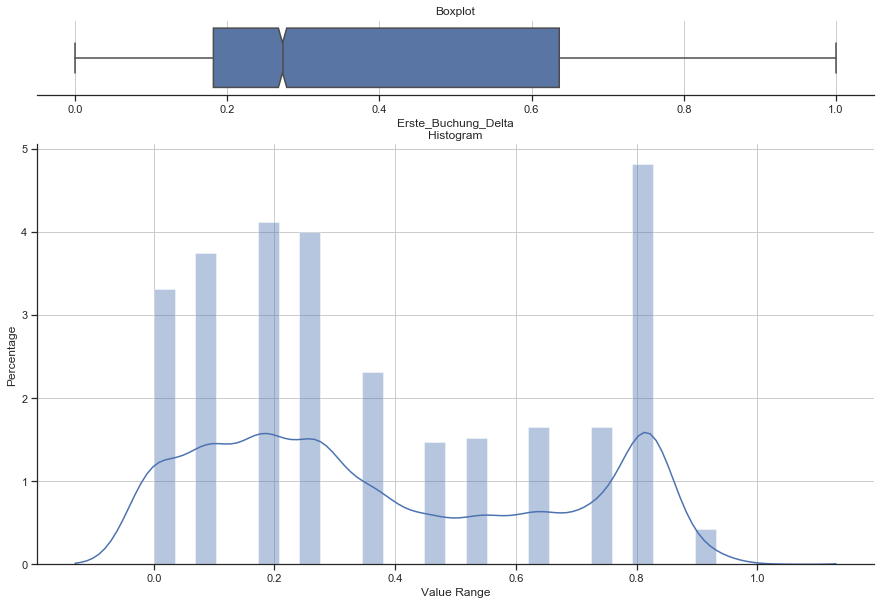

Target_Res_flg == True


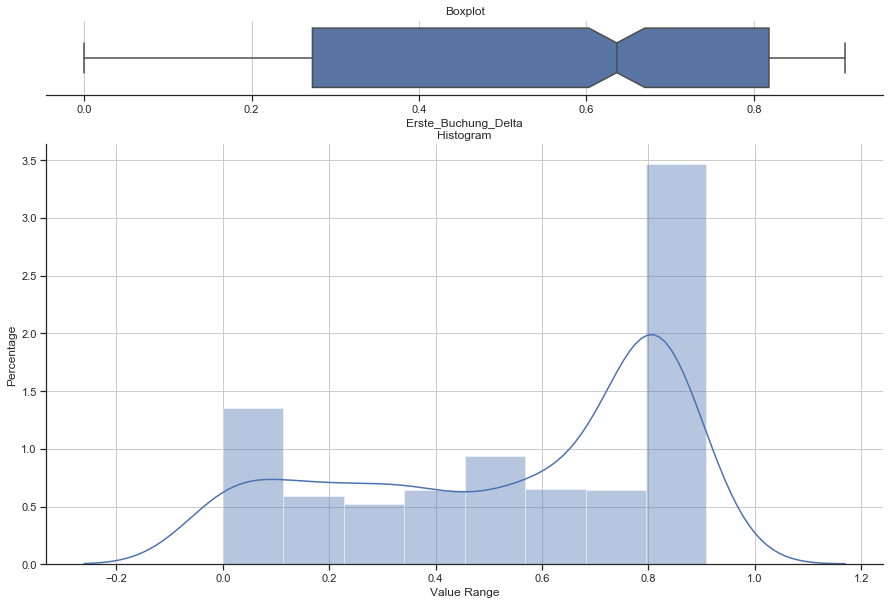

Target_Res_flg == False


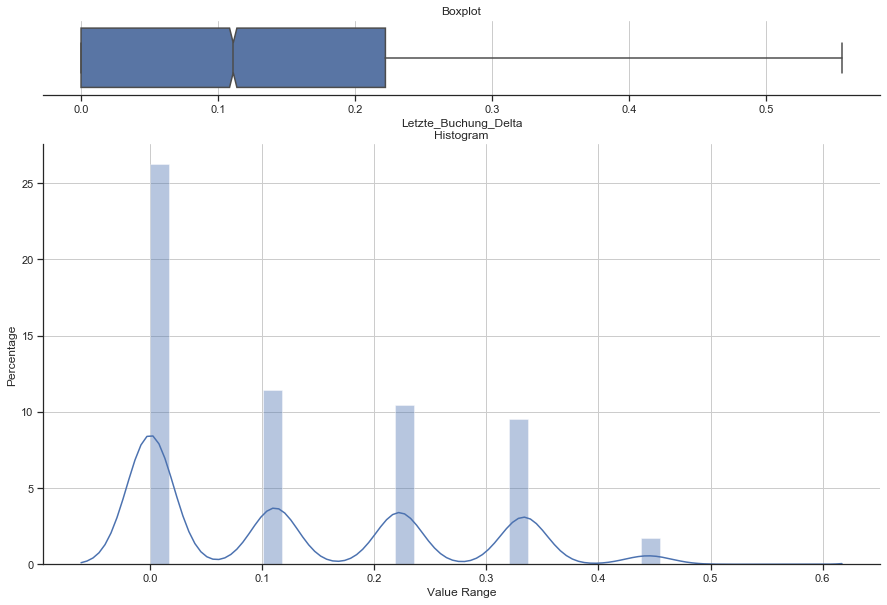

Target_Res_flg == True


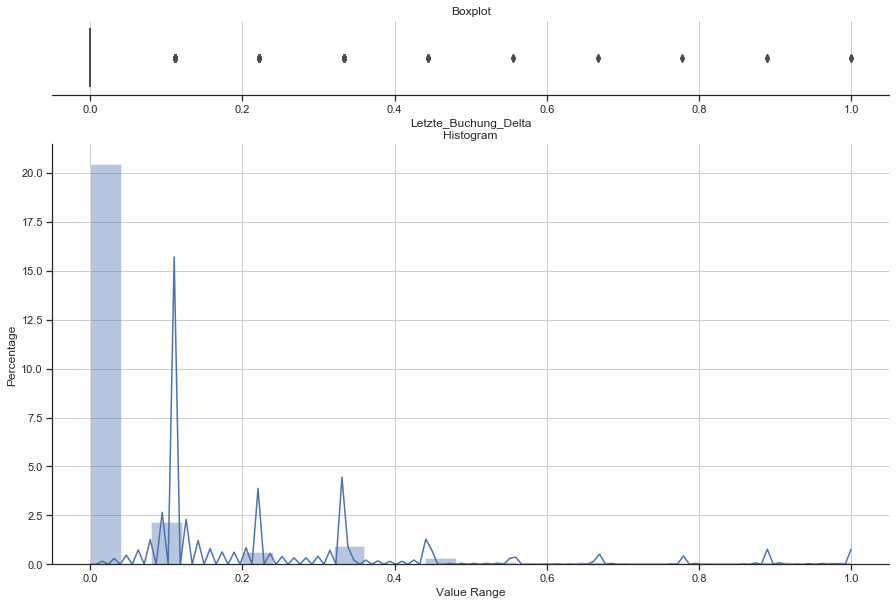

Target_Res_flg == False


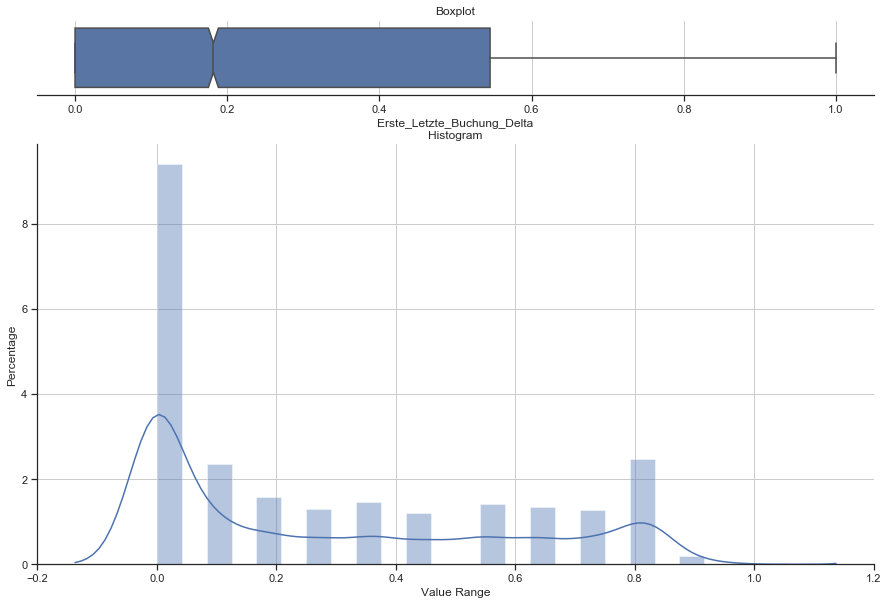

Target_Res_flg == True


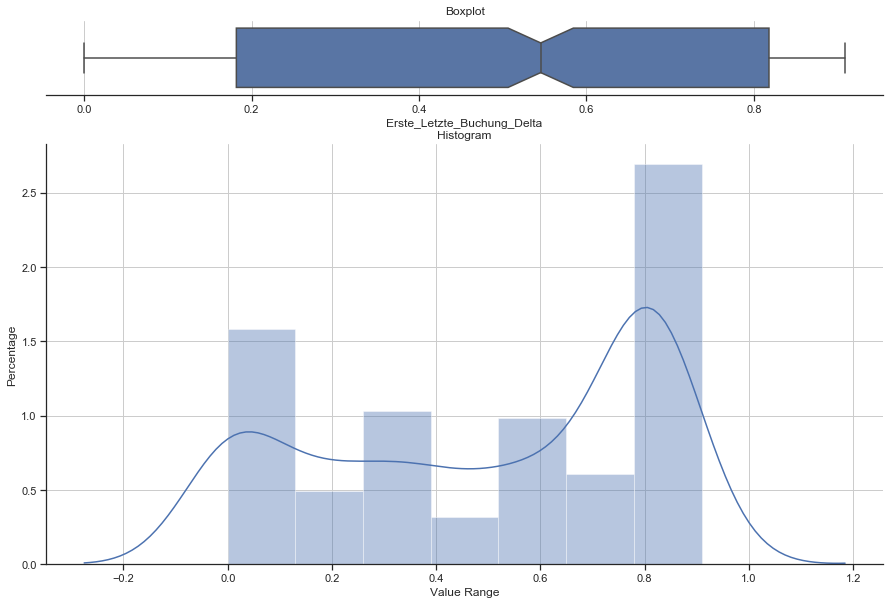

In [8]:
temp_df = training_all
print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Buchung_Delta"])

print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Letzte_Buchung_Delta"])


print("Target_Res_flg == False")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == False ,"Erste_Letzte_Buchung_Delta"])
print("Target_Res_flg == True")
boxplot_histogram(temp_df.loc[ temp_df.Target_Res_flg == True ,"Erste_Letzte_Buchung_Delta"])

## CRM Data

In [9]:
from vkprog_crm_prep  import crm_train_scoring

In [10]:
(crm_train_df, crm_score_df,feature_colnames_crm) = crm_train_scoring(day=7,
    month=10,
    year_score=2019,
    year_train=2018,
    year_span=4)

2019-10-10 17:29:09 [INFO] Start.
2019-10-10 17:29:09 [INFO] Started loading binary file
2019-10-10 17:29:09 [INFO] Reading from file C:\Users\stc\data\vkprog\crm_data_vkprog.feather
2019-10-10 17:29:09 [INFO] Finished loading binary file in 0.22s (0.34s CPU)
2019-10-10 17:29:20 [INFO] Finished.


In [11]:
feature_colnames_crm

['RY_0_Anz_Besprechung',
 'RY_1_Anz_Besprechung',
 'RY_2_Anz_Besprechung',
 'RY_3_Anz_Besprechung',
 'RY_0_Anz_Besuch',
 'RY_1_Anz_Besuch',
 'RY_2_Anz_Besuch',
 'RY_3_Anz_Besuch',
 'RY_0_Anz_Brief_Dankeskarte',
 'RY_1_Anz_Brief_Dankeskarte',
 'RY_2_Anz_Brief_Dankeskarte',
 'RY_3_Anz_Brief_Dankeskarte',
 'RY_0_Anz_E-Mail',
 'RY_1_Anz_E-Mail',
 'RY_2_Anz_E-Mail',
 'RY_3_Anz_E-Mail',
 'RY_0_Anz_Event_Veranstaltung',
 'RY_1_Anz_Event_Veranstaltung',
 'RY_2_Anz_Event_Veranstaltung',
 'RY_3_Anz_Event_Veranstaltung',
 'RY_0_Anz_Telefon',
 'RY_1_Anz_Telefon',
 'RY_2_Anz_Telefon',
 'RY_3_Anz_Telefon',
 'RY_0_Anz_Anderes',
 'RY_1_Anz_Anderes',
 'RY_2_Anz_Anderes',
 'RY_3_Anz_Anderes',
 'Letzter_Kontakt_Delta_Anderes',
 'Letzter_Kontakt_Delta_Besprechung',
 'Letzter_Kontakt_Delta_Besuch',
 'Letzter_Kontakt_Delta_Brief_Dankeskarte',
 'Letzter_Kontakt_Delta_E-Mail',
 'Letzter_Kontakt_Delta_Event_Veranstaltung',
 'Letzter_Kontakt_Delta_Telefon',
 'Letzter_Kontakt_Delta_global']

In [12]:
def scaling_crm_add2master(master_df,crm_df,feature_colnames_crm):
    container_df = pd.merge(master_df, crm_df,how="left", on="Endkunde_NR")

    for col_name in list(np.compress(['RY'== x[0:2] for x in feature_colnames_crm],feature_colnames_crm)):
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(0)
        max_ = np.max(container_df.loc[:,col_name])
        min_ = np.min(container_df.loc[:,col_name])
        container_df.loc[:,col_name] = (container_df.loc[:,col_name] - min_)/(max_ - min_)

    for col_name in list(np.compress(['Letzter'== x[0:7] for x in feature_colnames_crm],feature_colnames_crm)):
        max_ = np.nanmax(container_df.loc[:,col_name]) # those who have never been contacted will be put together with the max-ones.
        container_df.loc[:,col_name] = container_df.loc[:,col_name].fillna(max_)
        container_df.loc[:,col_name] = (container_df.loc[:,col_name] - min_)/(max_ - min_)
    
    return container_df

In [13]:
training_all = scaling_crm_add2master(master_df=training_all,crm_df=crm_train_df,feature_colnames_crm=feature_colnames_crm)
scoring_all  = scaling_crm_add2master(master_df=scoring_all, crm_df=crm_score_df,feature_colnames_crm=feature_colnames_crm)

# Modeling

## Define Columns: Features versus Targets

In [14]:
from itertools import compress
features = feature_colnames_bd + feature_colnames_dates + feature_colnames_branchen + feature_colnames_crm
#feature_columns = list(compress(features,["Target" not in s for s in features]))

feature_columns_boolean = pd.Series(features).str.match('^Target')
feature_columns = pd.Series(features).loc[~feature_columns_boolean]

feature_columns_boolean = pd.Series(training_all.columns).str.match('^Target')
target_columns = pd.Series(training_all.columns).loc[feature_columns_boolean]

del feature_columns_boolean

#target_columns  = list(compress(training_all.columns,["Target" in s for s in training_all.columns]))

In [15]:
print(len(feature_columns))
print(target_columns)

338
214               Target_Aus_flg
215               Target_Res_flg
216    Target_Sum_Aus_RY_0_KW_41
217    Target_Sum_Res_RY_0_KW_41
dtype: object


In [16]:
#["Target" not in s for s in features]
#features
#display(feature_columns)

## Split ``training_all`` into training-set (``X_train``,``y_train``) and test-set (``X_test``,``y_test``)

In [17]:
df_features = training_all.loc[:,feature_columns].to_numpy()
df_target   = training_all.loc[:, "Target_Res_flg"].to_numpy()

df_scoring_features = scoring_all.loc[:,feature_columns].to_numpy()

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #df_features, df_target, train_size=0.80, random_state=42)
    df_features, df_target, train_size=0.75, random_state=42)

In [19]:
print("Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("\ndf_scoring_features", df_scoring_features.shape)

Shape:
X_train: (13218, 338)
y_train: (13218,)
X_test: (4407, 338)
y_test: (4407,)

df_scoring_features (17488, 338)


In [20]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(stats.describe(y_test))


y_train:
0
False    12732
True       486
Name: 0, dtype: int64
DescribeResult(nobs=13218, minmax=(False, True), mean=0.03676804357694054, variance=0.03541883413948755, skewness=4.922976985573265, kurtosis=22.235702400484044)

y_test:
0
False    4235
True      172
Name: 0, dtype: int64
DescribeResult(nobs=4407, minmax=(False, True), mean=0.03902881778987974, variance=0.0375140815569997, skewness=4.760536414604853, kurtosis=20.66270695477884)


## Balance Training Dataset

In [21]:
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [22]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

y_train_balanced:
0
False    12732
True     12732
Name: 0, dtype: int64
DescribeResult(nobs=25464, minmax=(False, True), mean=0.5, variance=0.2500098181675372, skewness=0.0, kurtosis=-2.0)


## Feature selection: SelectkBest

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

In [23]:
#from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # ANOVA F-value
from sklearn.feature_selection import mutual_info_classif
from itertools import compress

In [24]:
%%time
#Wall time: 54 s

# use f_classif (the default) and SelectPercentile to select 50% of features
"""
select = SelectPercentile(score_func=mutual_info_classif,
                          percentile=100)
"""
select = SelectKBest(score_func=mutual_info_classif,
            k=150 # How many features? (currently 219 is max)
            )
select.fit(X_train_balanced, y_train_balanced)

mask = select.get_support() # boolean array.

Wall time: 54.4 s


In [25]:
print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_balanced[:,mask].shape: {}".format(X_train_balanced[:,mask].shape))

X_train_balanced.shape: (25464, 338)
X_train_balanced[:,mask].shape: (25464, 150)


In [26]:
feature_columns  = feature_columns.loc[mask]
X_train_balanced = X_train_balanced[:,mask]
X_train          = X_train[:,mask]
X_test           = X_test[:,mask]
X_scoring        = df_scoring_features[:,mask]

In [27]:
print("X_scoring:",X_scoring.shape)

X_scoring: (17488, 150)


## Model Training

### Logistic Regression (base model)

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
%%time
# Wall time: 1min 13s
logreg_C1000 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=1000 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C1000.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C1000.score(X_test, y_test)))

Training set score: 0.814
Test set score: 0.834
Wall time: 52.7 s


In [30]:
%%time
# Wall time: 543 ms
logreg_C0001 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=0.001 #adjustable, bigger mean less restriction on coefficients
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg_C0001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg_C0001.score(X_test, y_test)))

Training set score: 0.752
Test set score: 0.815
Wall time: 433 ms


#### Plot Coefficients

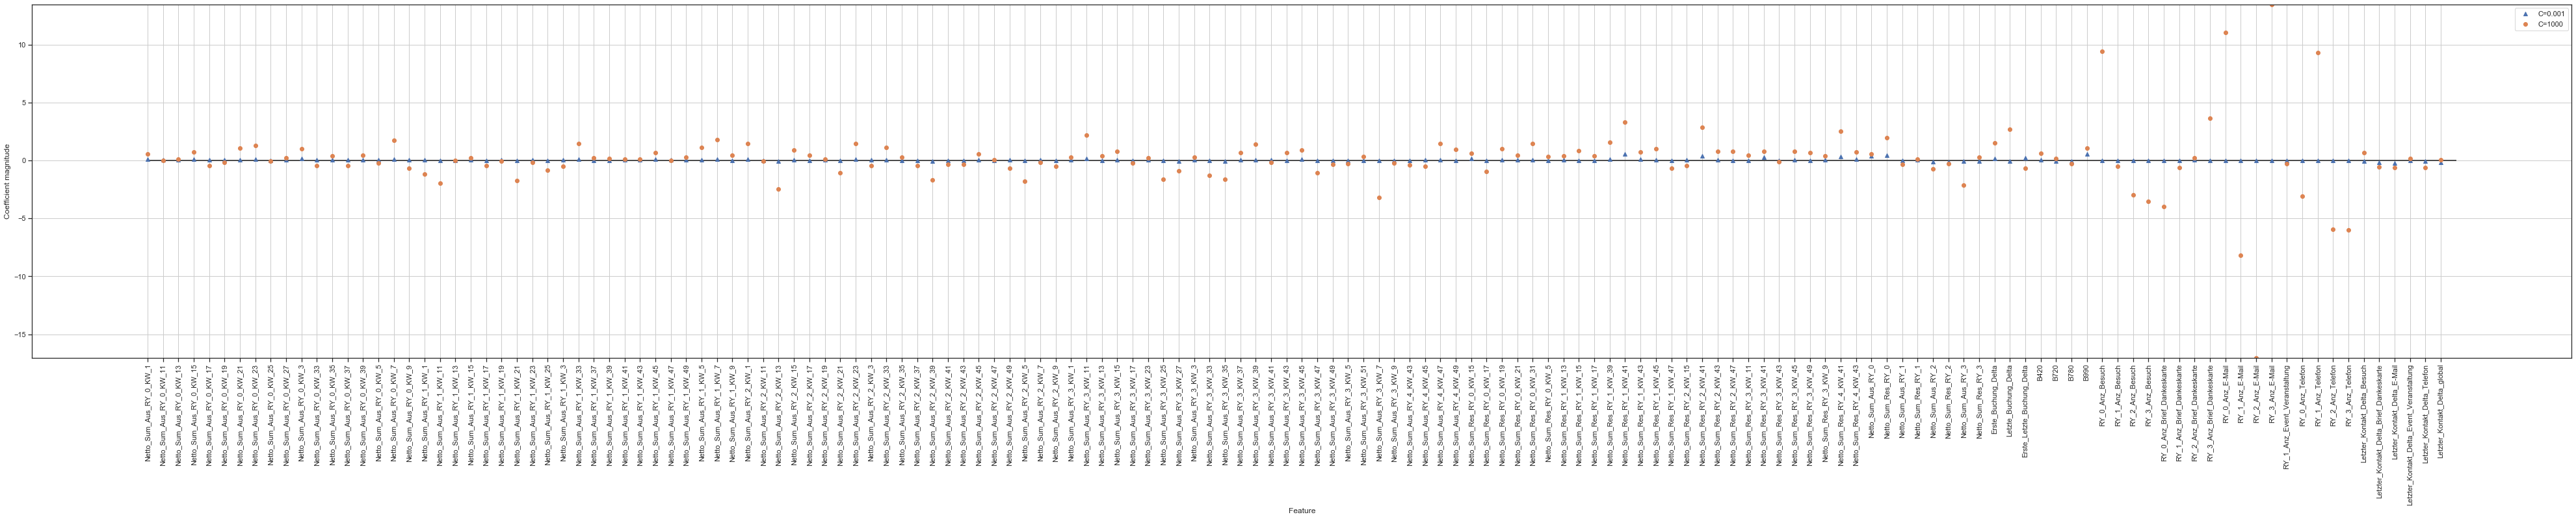

In [31]:
# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg_C0001.coef_.T, '^', label="C=0.001")
plt.plot(logreg_C1000.coef_.T,    'o', label="C=1000")
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

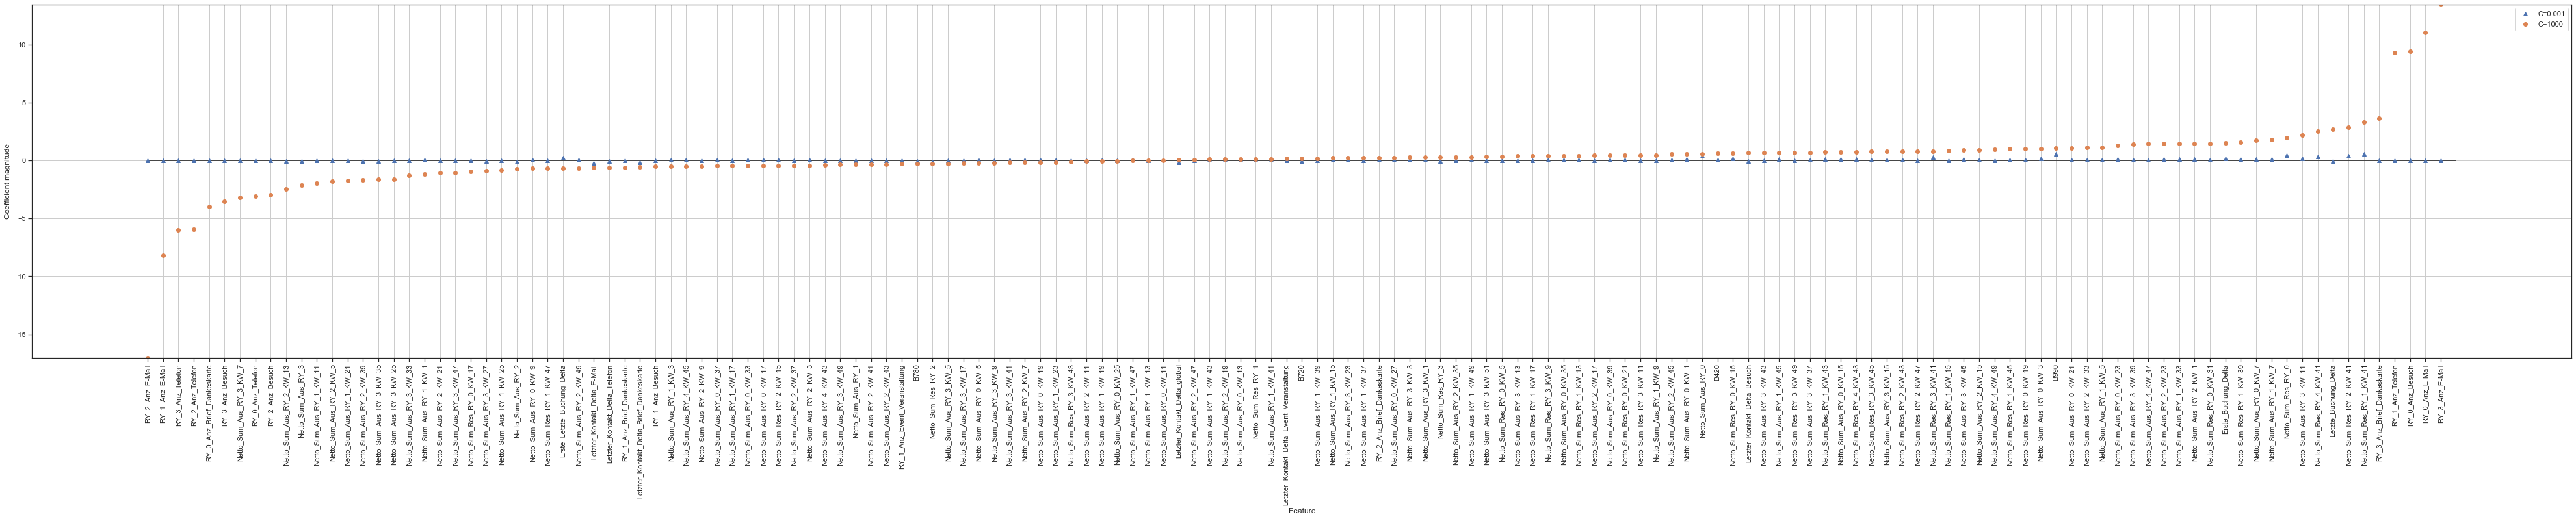

In [32]:
test_df = pd.DataFrame(data={'feature': pd.Series(feature_columns), 
                             'C1000': list(logreg_C1000.coef_.T),
                            'C0001': list(logreg_C0001.coef_.T)})
test_df = test_df.sort_values(by=['C1000']).reset_index()

# %% Plot: Compare LogReg-coefficients for different C (1000, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(test_df.loc[:,'C0001'], '^', label="C=0.001")
plt.plot(test_df.loc[:,'C1000'], 'o', label="C=1000")
plt.xticks(range(len(feature_columns)), test_df.loc[:,'feature'], rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg_C1000.coef_.T), max(logreg_C1000.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

### Model Training: Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time 
# Wall time: 13min
forest_01 = RandomForestClassifier(n_estimators=10**5,
                                #max_depth=8,
                                random_state=42,
                                n_jobs=-1)
forest_01.fit(X_train_balanced, y_train_balanced)
#forest_01.fit(X_train, y_train)

In [ ]:
%%time
# %% Validate Accuracy
print("Accuracy on balanced training set: {:.3f}".format(forest_01.score(X_train_balanced,y_train_balanced)))
print("Accuracy on training set: {:.3f}".format(forest_01.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(forest_01.score(X_test,     y_test)))

In [ ]:
# %% Plot: Feature importance
def plot_feature_importances(model,feature_columns,figsize=(20,100)):
    from operator import itemgetter
    dict_feature_importance = sorted(dict(zip(feature_columns,model.feature_importances_)).items(), key=itemgetter(1))
    n_features              = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.barh(np.arange(n_features),
             [y for (x,y) in dict_feature_importance],
             align='center')
    plt.yticks(np.arange(n_features), [x for (x,y) in dict_feature_importance])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

In [ ]:
plot_feature_importances(forest_01,feature_columns)

# Model Validation

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
%%time

def confusion_matrices(X_test,y_test):
    global pred_forest_01, pred_logreg_C0001, pred_logreg_C1000
    
    pred_forest_01          = forest_01.predict(X_test)
    pred_logreg_C0001       = logreg_C0001.predict(X_test)
    pred_logreg_C1000       = logreg_C1000.predict(X_test)


    # Wall time: 20.9ms

    confusion_logreg_C0001       = confusion_matrix(y_test, pred_logreg_C0001)
    df_confusion_logreg_C0001    = pd.DataFrame(confusion_logreg_C0001, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_logreg_C1000       = confusion_matrix(y_test, pred_logreg_C1000)
    df_confusion_logreg_C1000    = pd.DataFrame(confusion_logreg_C1000, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    confusion_forest_01          = confusion_matrix(y_test, pred_forest_01)
    df_confusion_forest_01       = pd.DataFrame(confusion_forest_01, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

    print("Test set balance:")
    print(pd.Series(y_test).value_counts())

    print("\nConfusion Matrices:")

    print("\nRandom Forest (forest_01):")
    display(df_confusion_forest_01)

    print("\nLogistic Regression C=0.001:")
    display(df_confusion_logreg_C0001)

    print("\nLogistic Regression C=1000:")
    display(df_confusion_logreg_C1000)

In [ ]:
confusion_matrices(X_train_balanced,y_train_balanced)

In [ ]:
confusion_matrices(X_train,y_train)

In [ ]:
confusion_matrices(X_test,y_test)

1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$ <-- Optimising target!
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


## Classification Report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
%%time
## Wall time: 9.94ms

print("\n")
print("Logistic Regression C=0.001:")
print(classification_report(y_test,
                            pred_logreg_C0001,
                            target_names=["not booking = 0", "booking = 1"]))

print("Logistic Regression C=1000:")
print(classification_report(y_test,
                            pred_logreg_C1000,
                            target_names=["not booking = 0", "booking = 1"]))

print("Random Forest:")
print(classification_report(y_test,
                            pred_forest_01,
                            target_names=["not booking = 0", "booking = 1"]))

## Precision-Recall Curve

In [ ]:
logreg_C1000.predict_proba(X_test)[:,1]

In [ ]:
from sklearn.metrics import precision_recall_curve

def prec_rec_values(X_test,y_test):
    global precision_forest_01, recall_forest_01, thresholds_forest_01, precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001,precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 
    
    # LogReg C=0.001
    precision_logreg_C0001, recall_logreg_C0001, thresholds_logreg_C0001 = precision_recall_curve(
        y_test, 
        logreg_C0001.predict_proba(X_test)[:,1])
    
    # LogReg C=1000
    precision_logreg_C1000, recall_logreg_C1000, thresholds_logreg_C1000 = precision_recall_curve(
        y_test, 
        logreg_C1000.predict_proba(X_test)[:,1])
    
    # RandomForestClassifier has predict_proba, but not decision_function
    precision_forest_01, recall_forest_01, thresholds_forest_01 = precision_recall_curve(
        y_test,
        forest_01.predict_proba(X_test)[:, 1])
    
    

In [ ]:
%%time
# Wall time: 22.4s

def prec_rec_curve(X_train,y_train):
    prec_rec_values(X_train,y_train)

    plt.figure(figsize=(15,12))
    plt.grid()

    def optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name,dot):
        optimum_idx = pd.Series.idxmin(np.power(1-pd.Series(precision_forest_01),2)+np.power(1-pd.Series(recall_forest_01),2))
        return plt.plot(precision_forest_01[optimum_idx],
                     recall_forest_01[optimum_idx],
                     dot,
                     markersize=10,
                     label=f"{name}: threshold {thresholds_forest_01[optimum_idx]}",
                     fillstyle="none",
                     c='k',
                     mew=2)

    optimum_point(precision_forest_01,recall_forest_01,thresholds_forest_01,name="forest_01",dot='o')
    optimum_point(precision_logreg_C0001,recall_logreg_C0001,thresholds_logreg_C0001,name="logreg_C0001",dot='x')
    optimum_point(precision_logreg_C1000,recall_logreg_C1000,thresholds_logreg_C1000,name="logreg_C1000",dot='+')

    plt.plot(precision_logreg_C0001, recall_logreg_C0001, label="Logistic Regression, C=0.001")
    plt.plot(precision_logreg_C1000, recall_logreg_C1000, label="Logistic Regression, C=1000")
    plt.plot(precision_forest_01, recall_forest_01, label="Random Forest")

    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend(loc="best")

    plt.show()

In [ ]:
prec_rec_curve(X_train_balanced,y_train_balanced)

In [ ]:
prec_rec_curve(X_train,y_train)

In [ ]:
prec_rec_curve(X_test,y_test)

In [ ]:
#boxplot_histogram(thresholds_logreg_C0001)

In [ ]:
%%time
#Wall time: 19.7 s

from sklearn.metrics import average_precision_score # Area under the Recall/Precision-curves

avg_precision_logreg_C0001 = average_precision_score(y_test,
                                               logreg_C0001.predict_proba(X_test)[:, 1])

avg_precision_logreg_C1000 = average_precision_score(y_test,
                                               logreg_C1000.predict_proba(X_test)[:, 1])

avg_precision_forest_01 = average_precision_score(y_test,
                                               forest_01.predict_proba(X_test)[:, 1])


print("Average Precision of LogReg C=0.001: {:.3f}".format(avg_precision_logreg_C0001))
print("Average Precision of LogReg C=1000:  {:.3f}".format(avg_precision_logreg_C1000))
print("Average Precision of forest_01:      {:.3f}".format(avg_precision_forest_01))

## Receiver Operating Characteristics (ROC) and AUC


In [ ]:
%%time
from sklearn.metrics import roc_curve
def roc_curve_graph(X_test,y_test):
    global fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001, fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000, fpr_forest_01, tpr_forest_01, thresholds_forest_01
    fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001 = roc_curve(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    fpr_logreg_C1000, tpr_logreg_C1000, thresholds_logreg_C1000 = roc_curve(y_test, logreg_C1000.predict_proba(X_test)[:, 1])
    fpr_forest_01, tpr_forest_01, thresholds_forest_01 = roc_curve(y_test, forest_01.predict_proba(X_test)[:, 1])

    def threshold_dot_50perc(fpr_forest_01,tpr_forest_01,thresholds_forest_01,name,dot):

        close_default_index_forest_01 = pd.Series.idxmin(np.power(1-pd.Series(tpr_forest_01),2)+np.power(pd.Series(fpr_forest_01),2))
        return plt.plot(fpr_forest_01[close_default_index_forest_01], tpr_forest_01[close_default_index_forest_01],
                 dot,
                 markersize=10,
                 label=f"{name} threshold: {thresholds_forest_01[close_default_index_forest_01]}",
                 fillstyle="none",
                 c='k',
                 mew=2)


    plt.figure(figsize=(15,12))
    plt.grid()

    plt.plot(fpr_forest_01,fpr_forest_01, linestyle='dotted', label="base line")

    plt.plot(fpr_logreg_C0001, tpr_logreg_C0001, label="logreg_C0001")
    plt.plot(fpr_logreg_C1000, tpr_logreg_C1000, label="logreg_C1000")
    plt.plot(fpr_forest_01,    tpr_forest_01,    label="forest_01")


    plt.xlabel("False-Postive Rate (FPR)")
    plt.ylabel("True-Positive Rate (TPR) aka. Recall")

    # find threshold closest to zero
    threshold_dot_50perc(fpr_forest_01,tpr_forest_01,     thresholds_forest_01,'forest_01',dot='^')
    threshold_dot_50perc(fpr_logreg_C0001, tpr_logreg_C0001, thresholds_logreg_C0001,'logreg_C0001',dot='x')
    threshold_dot_50perc(fpr_logreg_C1000,tpr_logreg_C1000,thresholds_logreg_C1000,'logreg_C1000',dot='+')

    plt.legend(loc=4)
    plt.show()

In [ ]:
%%time
# Wall time: 17.6s
from sklearn.metrics import roc_auc_score

def roc_auc(X_test,y_test):
    forest_01_auc    = roc_auc_score(y_test,    forest_01.predict_proba(X_test)[:, 1])
    logreg_C0001_auc = roc_auc_score(y_test, logreg_C0001.predict_proba(X_test)[:, 1])
    logreg_C1000_auc = roc_auc_score(y_test, logreg_C1000.predict_proba(X_test)[:, 1])


    print("AUC for forest_01:    {:.3f}".format(forest_01_auc))
    print("AUC for logreg_C0001: {:.3f}".format(logreg_C0001_auc))
    print("AUC for logreg_C1000: {:.3f}".format(logreg_C1000_auc))

In [ ]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train_balanced,y_train_balanced)
roc_auc(X_train_balanced,y_train_balanced)

In [ ]:
%%time
#Wall time: 10.6 s
roc_curve_graph(X_train,y_train)
roc_auc(X_train,y_train)

In [ ]:
%%time
roc_curve_graph(X_test,y_test)
roc_auc(X_test,y_test)

## Recursive feature elimination with cross-validation

## Shapley values

https://medium.com/@santiagof/model-interpretability-making-your-model-confess-shapley-values-5fb95a10a624

# Scoring

## Score Class Probabilities (Booking: No/Yes)

In [ ]:
scoring_prob     = forest_01.predict_proba(X_scoring)
scoring_prob_df  = pd.DataFrame(scoring_prob, columns=["Prob_0","Prob_1"])
scoring_all_prob = (pd.merge(scoring_all,
                             scoring_prob_df,
                             left_index=True,
                             right_index=True
                            ).sort_values("Prob_1",ascending=False)
                   )

In [ ]:
scoring_all_prob.head()

## Cutoff

In [ ]:
boxplot_histogram(scoring_all_prob.loc[:,"Prob_1"])

In [ ]:
boxplot_histogram(np.log(scoring_all_prob.loc[:,"Prob_1"]),bins=60)

In [ ]:
np.exp(-2.1)

In [ ]:
scoring_all_prob.loc[scoring_all_prob.loc[:,"Prob_1"]>0.166,:].shape[0]

In [ ]:
training_all.loc[:,["Target_Res_flg","Endkunde_NR"]].groupby("Target_Res_flg").count()

In [ ]:
691/17312


# Appendix

## Mutual Information

In [60]:
%%time
mu_in = mutual_info_classif(X_train_balanced,y_train_balanced) / mutual_info_classif(y_train_balanced.reshape(-1,1),y_train_balanced)

Wall time: 24.6 s


In [61]:
print(mu_in.shape)
print(feature_columns.shape)

(150,)
(150,)


In [62]:
 mu_in_df = (pd.DataFrame({'Feature':            feature_columns,
                           'Mutual_Information': mu_in})
             .sort_values(by='Mutual_Information',
                          ascending=False)
             .reset_index(drop=True)
            )

In [63]:
display(mu_in_df.head(50))

,Feature,Mutual_Information
0,RY_0_Anz_E-Mail,0.674373
1,Letzter_Kontakt_Delta_global,0.640181
2,RY_1_Anz_E-Mail,0.638901
3,Letzter_Kontakt_Delta_E-Mail,0.620988
4,RY_2_Anz_E-Mail,0.595154
5,RY_3_Anz_E-Mail,0.527001
6,Erste_Letzte_Buchung_Delta,0.522588
7,Erste_Buchung_Delta,0.514881
8,Letzter_Kontakt_Delta_Brief_Dankeskarte,0.293462
9,Netto_Sum_Aus_RY_0,0.292939


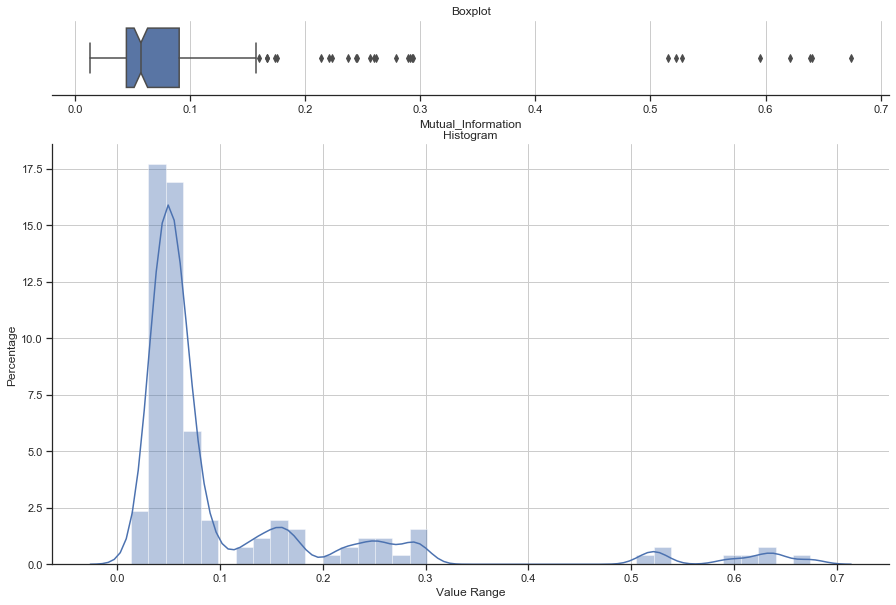

In [64]:
boxplot_histogram(mu_in_df.loc[:,'Mutual_Information'])

In [65]:
def mu_in_cutoff(cutoff):
    display(mu_in_df.loc[mu_in_df.loc[:,'Mutual_Information'] >= cutoff,:])

In [66]:
mu_in_cutoff(0.07)

,Feature,Mutual_Information
0,RY_0_Anz_E-Mail,0.674373
1,Letzter_Kontakt_Delta_global,0.640181
2,RY_1_Anz_E-Mail,0.638901
3,Letzter_Kontakt_Delta_E-Mail,0.620988
4,RY_2_Anz_E-Mail,0.595154
5,RY_3_Anz_E-Mail,0.527001
6,Erste_Letzte_Buchung_Delta,0.522588
7,Erste_Buchung_Delta,0.514881
8,Letzter_Kontakt_Delta_Brief_Dankeskarte,0.293462
9,Netto_Sum_Aus_RY_0,0.292939


In [67]:
mu_in_df['scaled'] = mu_in_df['Mutual_Information'] / mu_in_df['Mutual_Information'].sum()

In [68]:
mu_in_df['cum'] = mu_in_df['scaled'].cumsum()

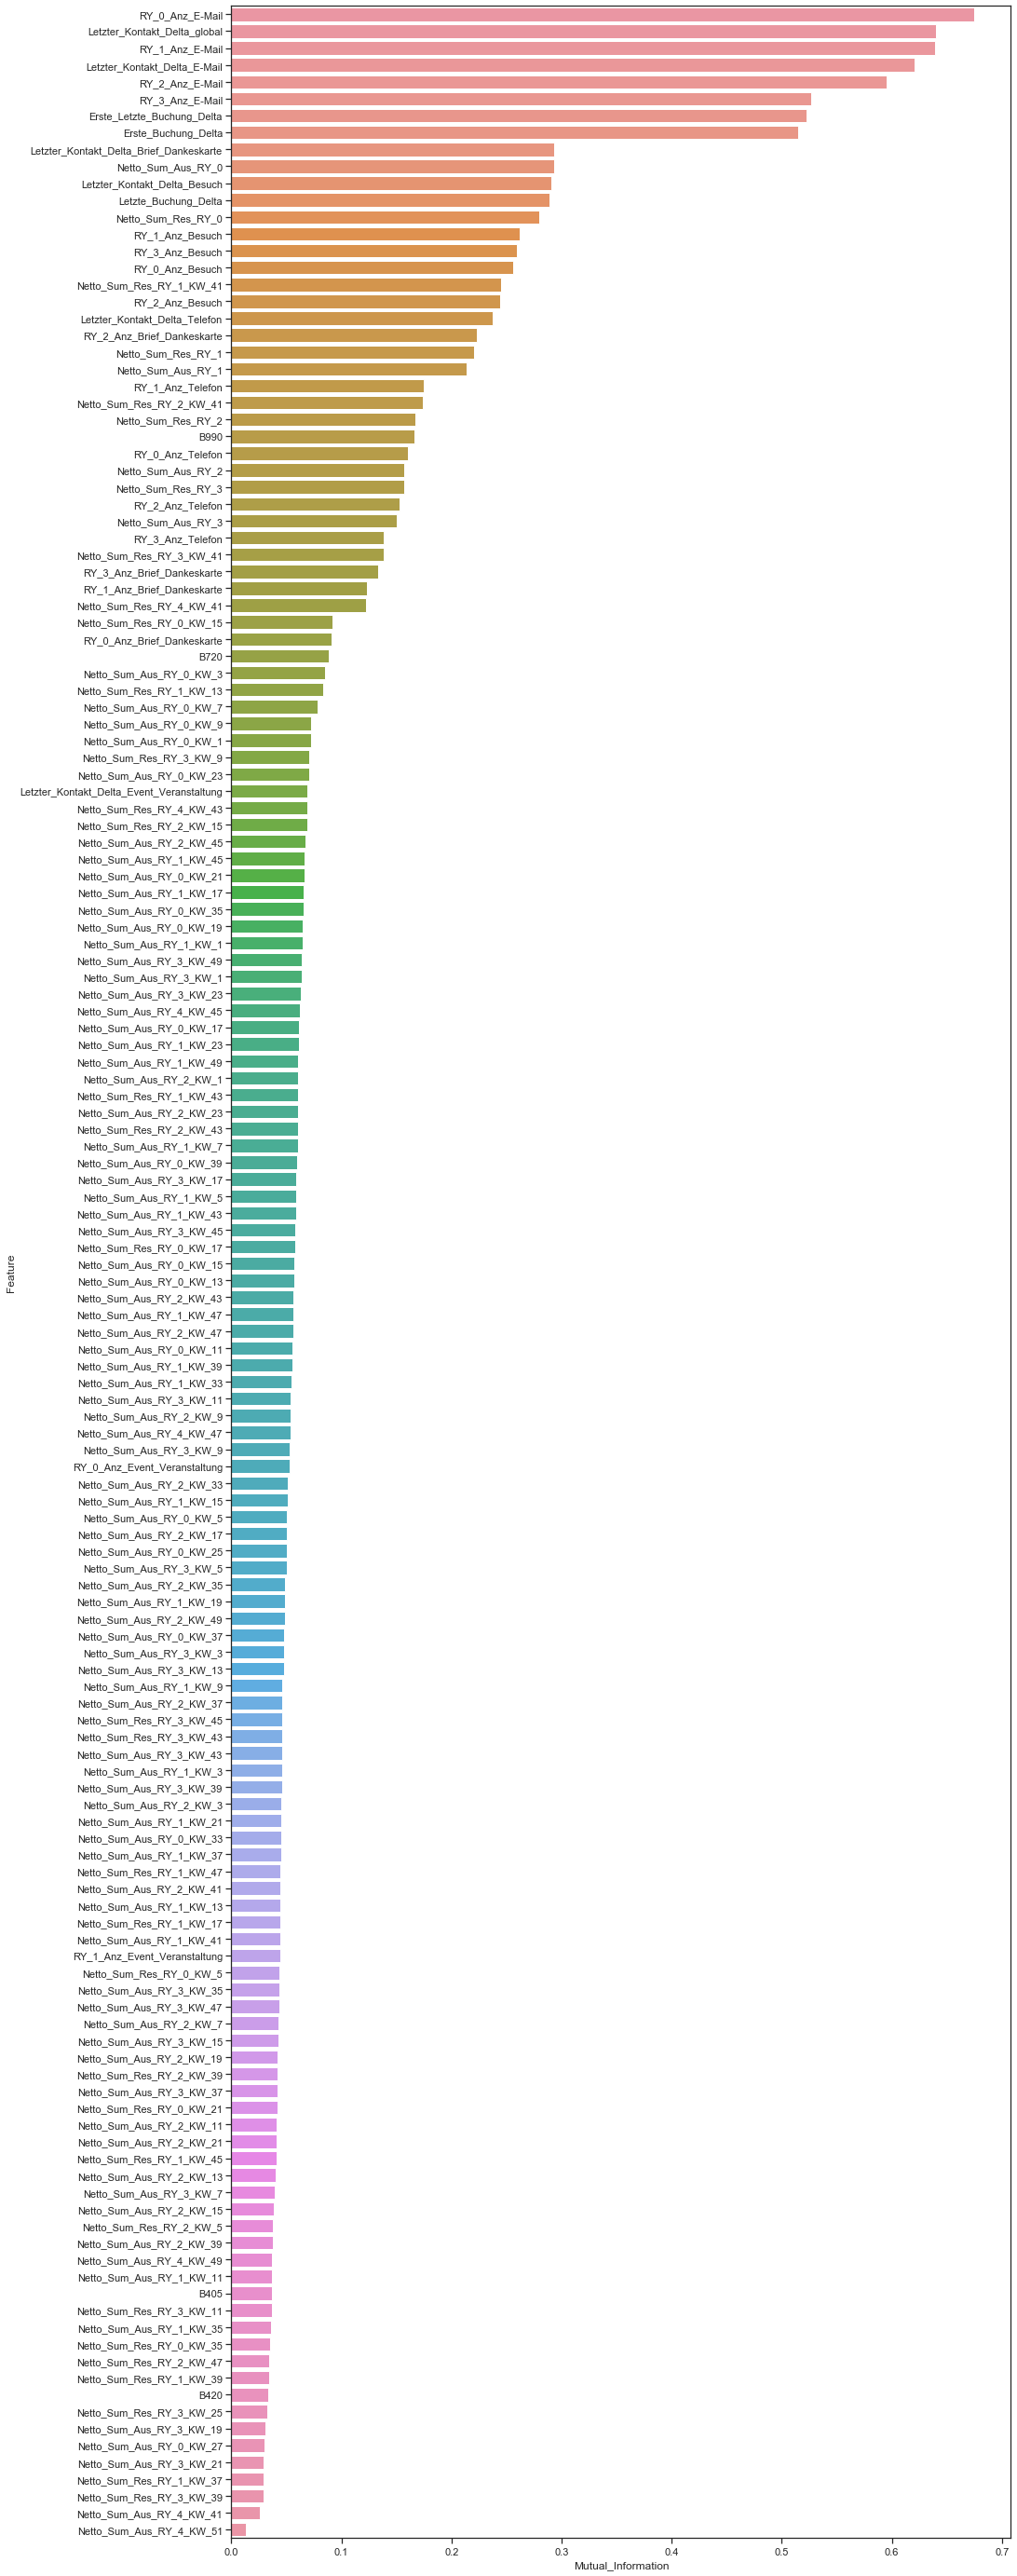

In [69]:
plt.figure(figsize=(15,50))
sns.barplot(x   = 'Mutual_Information',
            y   = 'Feature',
            data= mu_in_df)

## Bivariate Analysis

In [ ]:
training_all.describe()

In [ ]:
print(training_all.columns)

In [ ]:
def hexbin(dataset, first_feature,second_feature,gridsize=25):
    dataset.plot.hexbin(x=first_feature, y=second_feature , gridsize=gridsize, figsize=(12,8))

In [ ]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(training_all,
                      hue="Target_Res_flg",
                      col="Target_Res_flg",
                      height=10
                     )

g.map(hexbin,
      "Netto_Sum_Aus_RY_0_KW_1",
      "Erste_Buchung_Delta",
      extent=[0, 1, 0, 1]
     )

In [ ]:
sns.axes_style("darkgrid")

sns.pairplot(data   = training_all.loc[:,["Target_Res_flg"]+list(mu_in_df.head(20).loc[:,"Feature"])],
             diag_kind="kde",
             hue    = "Target_Res_flg",
             height =5
            ).savefig("derp.png")
